In [5]:
import glob
import nibabel
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import torch
from torch.utils.tensorboard import SummaryWriter
from nilearn import image, plotting
import pandas as pd
import sys,os
from natsort import natsorted
import logging
#monai and co.
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    EnsureType,
    Randomizable,
    LoadImaged,
    EnsureTyped,
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



/home/sebastian/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [35]:
filenames_4D = natsorted(glob.glob("/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_*/*4D*/*nii*"))
cases_paths = {}
for path in filenames_4D:
    cases_paths[path.split('.')[-2]] = path
print(len(cases_paths))

94


In [4]:
#Reading the AIF and the VOF for each case(line) with coordinates AIFx,AIFy,AIFz,VOFx,VOFy,VOFz 
aif_annotations = []
aif_annotations_file = open('/home/sebastian/experiments/aifnet/annotated_aif_vof_20cases','r')
aif_annotations_file.readline()
cases_annotations = {}
for line in aif_annotations_file:
    cases_annotations[line.split(',')[0]] = [np.array([int(line.split(',')[1]),int(line.split(',')[2]),int(line.split(',')[3])])- 1,
                                             np.array([int(line.split(',')[4]),int(line.split(',')[5]),int(line.split(',')[6])])-1]
aif_annotations_file.close()

print(cases_annotations)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sebastian/experiments/aifnet/annotated_aif_vof_20cases'

In [3]:
len(cases_annotations)

NameError: name 'cases_annotations' is not defined

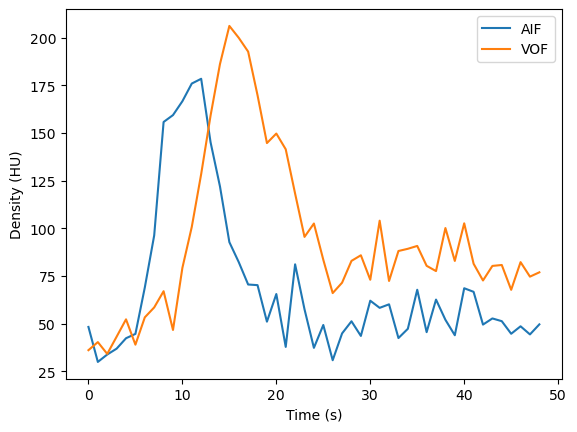

In [42]:
cur_case = '345575'
#Reading the case CTP sequence
fname = cases_paths[cur_case]
cur_nib = nib.load(fname)    
cur_num_sequence = cur_nib.get_fdata().shape[-1]
cur_num_sequence
ctp_vals = cur_nib.get_fdata()

AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
VOFx,VOFy,VOFz = cases_annotations[cur_case][1][0],cases_annotations[cur_case][1][1], cases_annotations[cur_case][1][2]


AIF = ctp_vals[AIFx,AIFy,AIFz,:]
VOF = ctp_vals[VOFx,VOFy,VOFz,:]

plt.plot(AIF)
plt.plot(VOF)
plt.legend(['AIF', 'VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Density (HU)')
plt.show()


NameError: name 'cut_volume' is not defined

In [22]:
len(filenames_4D)

94

In [11]:
min_num_sequence = 999
max_num_sequence = 0
min_fname = ''
max_fname = ''
for fname in filenames_4D:
    cur_nib = nib.load(fname)    
    cur_num_sequence = cur_nib.get_data().shape[-1]
    #if cur_num_sequence not in set(range(50,55)):
     #   continue
    print(fname)
    if cur_num_sequence < min_num_sequence:
        min_num_sequence = cur_num_sequence
        min_fname = fname
    if cur_num_sequence > max_num_sequence:
        max_num_sequence = cur_num_sequence
        max_fname = fname
    print(cur_num_sequence)
print("The minimum number of volumes in the sequence found was: "+ min_fname.split('.')[-2]   +" => " +str(min_num_sequence))
print("The maximum number of volumes in the sequence found was: " +  max_fname.split('.')[-2] +" => " + str(max_num_sequence))


/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_3/SMIR.Brain.XX.O.CT_4DPWI.345575/SMIR.Brain.XX.O.CT_4DPWI.345575.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_4/SMIR.Brain.XX.O.CT_4DPWI.345582/SMIR.Brain.XX.O.CT_4DPWI.345582.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_5/SMIR.Brain.XX.O.CT_4DPWI.345589/SMIR.Brain.XX.O.CT_4DPWI.345589.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_6/SMIR.Brain.XX.O.CT_4DPWI.345596/SMIR.Brain.XX.O.CT_4DPWI.345596.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_7/SMIR.Brain.XX.O.CT_4DPWI.345603/SMIR.Brain.XX.O.CT_4DPWI.345603.nii
49
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_8/SMIR.Br

<ipython-input-11-011fe4081302>:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  cur_num_sequence = cur_nib.get_data().shape[-1]


In [14]:
#The minimum number of volumes found in the ISLES18 training data was 43

In [60]:
class ISLES18Dataset(Randomizable, CacheDataset):
    resource = "http://biomedic.doc.ic.ac.uk/" \
        + "brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    def __init__(
        self,
        root_dir,
        aif_vof_file,
        cut_volume,
        section,
        transform,
        download=False,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
    ):
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        #Reading the nii files path for each of the 4D CTP images
        dataset_dir = os.path.join(root_dir, "TRAINING")
        tarfile_name = f"{dataset_dir}.tar"
        filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*"))
        cases_paths = {}
        for path in filenames_4D:
            cases_paths[path.split('.')[-2]] = path
        #Reading the AIF and the VOF for each case(line) with coordinates AIFx,AIFy,AIFz,VOFx,VOFy,VOFz 
        aif_annotations = []
        aif_annotations_file = open(aif_vof_file,'r')
        aif_annotations_file.readline()
        cases_annotations = {}
        for line in aif_annotations_file:
            cases_annotations[line.split(',')[0]] = [np.array([int(line.split(',')[1]),int(line.split(',')[2]),int(line.split(',')[3])])- 1,
                                                     np.array([int(line.split(',')[4]),int(line.split(',')[5]),int(line.split(',')[6])])-1]
        aif_annotations_file.close()
        
        aifs_cases = {}
        vofs_cases = {}
        self.datalist = []
        for cur_case in cases_annotations.keys():
            AIFx,AIFy,AIFz = cases_annotations[cur_case][0][0],cases_annotations[cur_case][0][1], cases_annotations[cur_case][0][2]
            VOFx,VOFy,VOFz = cases_annotations[cur_case][1][0],cases_annotations[cur_case][1][1], cases_annotations[cur_case][1][2]
            fname = cases_paths[cur_case]
            cur_nib = nib.load(fname)    
            ctp_vals = cur_nib.get_fdata()
            AIF = ctp_vals[AIFx,AIFy,AIFz,:]
            VOF = ctp_vals[VOFx,VOFy,VOFz,:]
            aifs_cases[cur_case] = AIF[0:cut_volume] #Since not all the CTP sequences have the same #volumes
            vofs_cases[cur_case] = VOF[0:cut_volume] #Since not all the CTP sequences have the same #volumes
            self.datalist.append({"image": fname, "label": [aifs_cases[cur_case],vofs_cases[cur_case]]})
            #print(len(aifs_cases[cur_case]))
            #print(cases_annotations) 
        print(self.datalist)
        print("loaded : " + str(len(self.datalist)) +" cases from a total of " + str(len(filenames_4D)))

        data = self._generate_data_list()
        super().__init__(
            data, transform, cache_num=cache_num,
            cache_rate=cache_rate, num_workers=num_workers,
        )

    def randomize(self, data=None):
        self.rann = self.R.random()

    def _generate_data_list(self):
        data = []
        for d in self.datalist:
            self.randomize()
            if self.section == "training":
                if self.rann < self.val_frac + self.test_frac:
                    continue
            elif self.section == "validation":
                if self.rann >= self.val_frac:
                    continue
            elif self.section == "test":
                if self.rann < self.val_frac or \
                        self.rann >= self.val_frac + self.test_frac:
                    continue
            else:
                raise ValueError(
                    f"Unsupported section: {self.section}, "
                    "available options are ['training', 'validation', 'test']."
                )
            data.append(d)
        return data


In [61]:
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training/'
aif_annotations_path = '/home/sebastian/experiments/aifnet/annotated_aif_vof.csv'
minimum_number_volumes_ctp = 43
train_ds = ISLES18Dataset(
    root_dir=root_dir,
    aif_vof_file=aif_annotations_path,
    cut_volume=minimum_number_volumes_ctp,
    section="training",
    transform=Compose([LoadImaged("image"), EnsureTyped("image")])
)


[{'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii', 'label': [array([ 65.17546844,  67.88008881,  71.38324738,  71.16088104,
        68.80565643,  50.76747894,  70.0555954 ,  73.96856689,
        72.30402374,  85.19799042,  47.89317703,  65.41912079,
        69.46140289,  63.03180313,  76.71797943, 117.90959167,
       122.22020721, 200.00575256, 296.57162476, 321.24246216,
       351.80267334, 363.67218018, 362.23324585, 363.32443237,
       351.73028564, 320.06192017, 253.75646973, 227.79251099,
       206.17881775, 190.67295837, 172.93933105, 148.33799744,
       139.99394226, 130.28613281, 120.06873322, 132.34762573,
        96.75967407,  93.7318573 , 109.64048767, 108.80736542,
        93.24468994,  93.63285828, 100.48235321]), array([ 53.45781708,  63.47758865,  62.5771637 ,  66.93271637,
        59.47294617,  76.37245178,  64.01821899,  69.82635498,
        60.91154861,  63.63569641,  53.

In [73]:
len(train_ds.data)

10

In [110]:
train_loader = DataLoader(train_ds, batch_size=3, shuffle=True,
                          num_workers=2, pin_memory=torch.cuda.is_available())

In [111]:
model = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=minimum_number_volumes_ctp, out_channels=minimum_number_volumes_ctp).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [112]:
batch_data['image'][0].shape

torch.Size([256, 256, 8, 49])

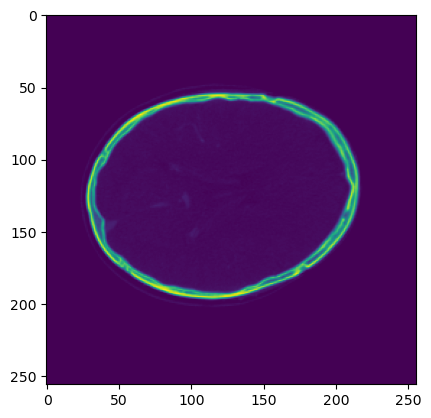

In [113]:
plt.imshow(batch_data['image'][1][:,:,2,25])
plt.show()

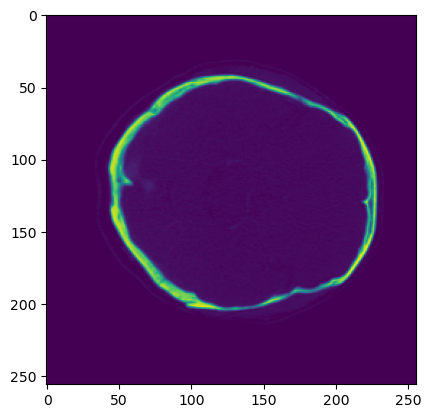

In [108]:
plt.imshow(batch_data['image'][0][:,:,2,25])
plt.show()

In [98]:
batch_data['image'][1][:,:,2,25].flatten()

tensor([-23., -23., -23.,  ..., -23., -23., -23.])

In [107]:
torch.max(batch_data['image'][1][:,:,2,25].flatten())

tensor(2357.0830)

In [114]:
for batch_data in train_loader:
    inputs, labels = batch_data['image'].to(device), batch_data['label'][0].to(device)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/monai/data/utils.py", line 272, in list_data_collate
    ret[k] = default_collate([d[k] for d in data])
  File "/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 56, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [256, 256, 4, 44] at entry 0 and [256, 256, 8, 49] at entry 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/monai/data/utils.py", line 285, in list_data_collate
    raise RuntimeError(re_str)
RuntimeError: stack expects each tensor to be equal size, but got [256, 256, 4, 44] at entry 0 and [256, 256, 8, 49] at entry 1
Collate error on the key 'image' of dictionary data.

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


In [119]:
len(batch_data['image'])

3

In [78]:
model.train()


DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(43, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(


In [ ]:
epoch_loss = 0
step = 0
step += 1
inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
optimizer.zero_grad()
outputs = model(inputs)
loss = loss_function(outputs, labels)

In [9]:
#In ISLES18 (Training) we have:
    ## 4D CTP volume sequence:        XX.O.CT_4DPWI.ID (Flow of the contrast agent a.k.a bolus seen in the sequence)
    ## Non-contrast CT volume:        XX.O.CT.ID (not easy to visually identify label from here)
    ## Segmentation mask:            XX.O.OT.ID (only given for the training dataset)
#Perfusion maps:
    ## Cerebral blood flow map:       XX.O.CT_CBF.ID    (Low contrast map, better seen in jetmap)
    ## Cerebral blood volume map:     XX.O.CT_CBV.ID    (High contrast map, not good overlay with the OT mask)
    ## Mean transition time map:      XX.O.CT_MTT.ID    (Very low specificity to differenciate penumbra and core)
    ## T max to the residue function: XX.O.CT_Tmax.ID   Very noisy and difficult to see the penumbra and core 

*************  case_58  *****************
/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.CT_MTT.345952/SMIR.Brain.XX.O.CT_MTT.345952.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 40.0
type of data : 
float64


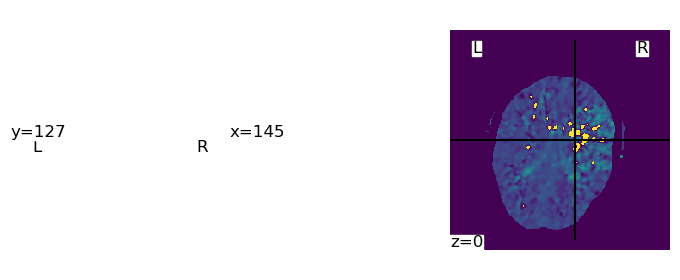

/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.OT.345953/SMIR.Brain.XX.O.OT.345953.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 1.0
type of data : 
uint8


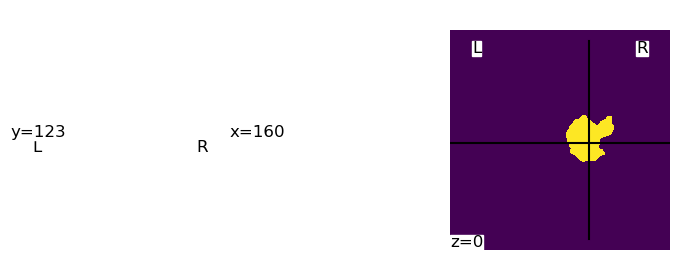

/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.CT_CBF.345950/SMIR.Brain.XX.O.CT_CBF.345950.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 5002.0
type of data : 
uint16


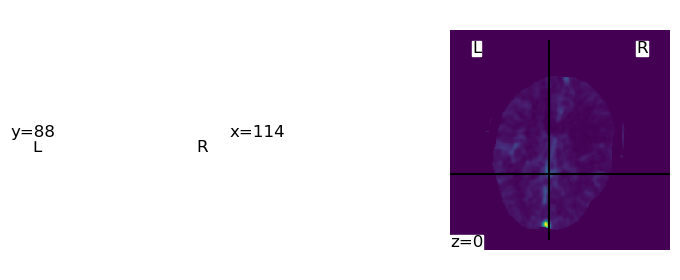

/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.CT_Tmax.345954/SMIR.Brain.XX.O.CT_Tmax.345954.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 40.0
type of data : 
float64


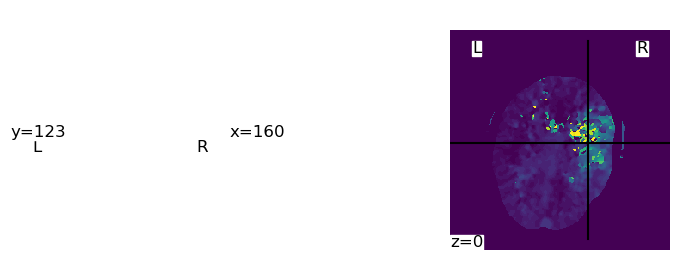

/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.CT_CBV.345951/SMIR.Brain.XX.O.CT_CBV.345951.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 774.0
type of data : 
uint16


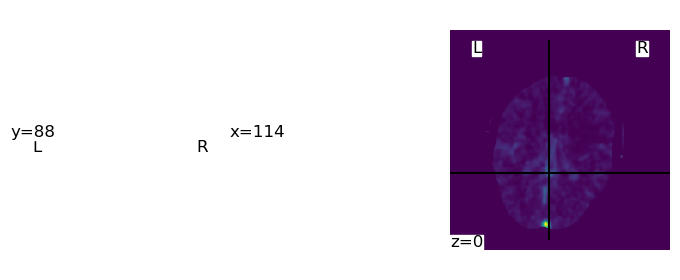

/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_58/SMIR.Brain.XX.O.CT.345949/SMIR.Brain.XX.O.CT.345949.nii=> image shape is : (256, 256, 2)
maximum value of image intensity is: 1557.0
type of data : 
int32


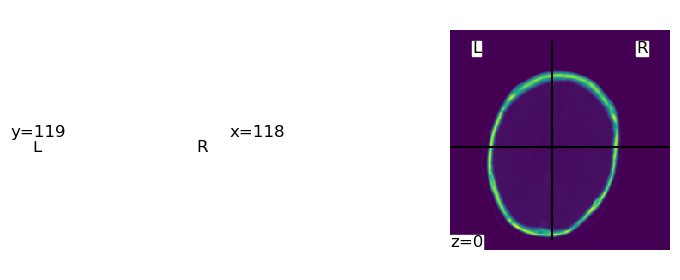

---------------------------------------------------------------------------


In [40]:
cases = [f for f in glob.glob("/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/"+'*')]
for case in cases[0:1]:    
    print('*************  ' + case.split("/")[-1] + '  *****************')
    files = [f for f in glob.glob(case+'/*/*.nii')]
    for f in files:
        if f.find("4DPWI")==-1: #Open all the files except the 4D sequences!
            CT_img = nib.load(f)
            print(f +  '=> image shape is : '+ str(CT_img.shape))
            img_data = CT_img.get_fdata()
            print('maximum value of image intensity is: '+ str(img_data.max()))
            print('type of data : ') 
            print(CT_img.get_data_dtype())

            plotting.plot_img(CT_img)
            plotting.show()
    print('---------------------------------------------------------------------------')